# EDA for Erin Robinson
## Real estate for social change



In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
plt.rcParams['figure.figsize'] = [15,8]
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import json

from datetime import datetime, date, time, timedelta


In [48]:
# import the data
df = pd.read_csv('data/eda.csv')
df.head()

id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  7129300520     3.000      1.000     1180.000  5650.000   1.000         NaN   
1  6414100192     3.000      2.250     2570.000  7242.000   2.000       0.000   
2  5631500400     2.000      1.000      770.000 10000.000   1.000       0.000   
3  2487200875     4.000      3.000     1960.000  5000.000   1.000       0.000   
4  1954400510     3.000      2.000     1680.000  8080.000   1.000       0.000   

   view  condition  grade  ...  yr_renovated  zipcode    lat     long  \
0 0.000          3      7  ...         0.000    98178 47.511 -122.257   
1 0.000          3      7  ...     19910.000    98125 47.721 -122.319   
2 0.000          3      6  ...           NaN    98028 47.738 -122.233   
3 0.000          5      7  ...         0.000    98136 47.521 -122.393   
4 0.000          3      8  ...         0.000    98074 47.617 -122.045   

   sqft_living15  sqft_lot15        date      price    house_id id.1  
0       1340.000    5650.000  2014-10-13 221900.000  7129300520    1  
1       1690.000    7639.000  2014-12-09 538000.000  6414100192    2  
2       2720.000    8062.000  2015-02-25 180000.000  5631500400    3  
3       1360.000    5000.000  2014-12-09 604000.000  2487200875    4  
4       1800.000    7503.000  2015-02-18 510000.000  1954400510    5  

[5 rows x 23 columns]

In [51]:
# clean up column names

# this column comes from sales
df.rename(columns={"id.1": "sales_id"}, inplace=True)

# this one is a duplicate from the DB join (for column "house_id")
#df.drop(columns=["id"], inplace=True)

#df.head()


# take care of the datatypes
# convert "date" into pandas timestamp
df['date2'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
### rename "date" to "sales_date" ???

# fix yr_renovated - has multiple flaws:
#  - is multplied by 10
#  - has NaN
#  - ist float instead of int64
# address these flaws but keep original column - in case we need to use the NaNs later on
# assumption: houses with 0 **or** NaN at yr_renovated have both not been renovated yet
df['yr_renovated_fix'] = (df['yr_renovated'].fillna(0) / 10).astype(int)

# UNSURE: convert yr_built, yr_renovated to timestamp/year ???
#df['yr_renovated_fix'] = pd.to_datetime(df['yr_renovated_fix'], format="%Y")
#df['yr_built'] = pd.to_datetime(df['yr_built'], format="%Y")

# add some calculated metrics to the dataframe
df['sqft_living_price'] = df['price'] / df['sqft_living']
df['sqft_lot_price'] = df['price'] / df['sqft_lot']

df['yr_sold'] = df['date2'].dt.year

df.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0     3.000      1.000     1180.000  5650.000   1.000         NaN 0.000   
1     3.000      2.250     2570.000  7242.000   2.000       0.000 0.000   
2     2.000      1.000      770.000 10000.000   1.000       0.000 0.000   
3     4.000      3.000     1960.000  5000.000   1.000       0.000 0.000   
4     3.000      2.000     1680.000  8080.000   1.000       0.000 0.000   

   condition  grade  sqft_above  ...  sqft_lot15        date      price  \
0          3      7    1180.000  ...    5650.000  2014-10-13 221900.000   
1          3      7    2170.000  ...    7639.000  2014-12-09 538000.000   
2          3      6     770.000  ...    8062.000  2015-02-25 180000.000   
3          5      7    1050.000  ...    5000.000  2014-12-09 604000.000   
4          3      8    1680.000  ...    7503.000  2015-02-18 510000.000   

     house_id  sales_id      date2  yr_renovated_fix  sqft_living_price  \
0  7129300520         1 2014-10-13                 0            188.051   
1  6414100192         2 2014-12-09              1991            209.339   
2  5631500400         3 2015-02-25                 0            233.766   
3  2487200875         4 2014-12-09                 0            308.163   
4  1954400510         5 2015-02-18                 0            303.571   

  sqft_lot_price  yr_sold  
0         39.274     2014  
1         74.289     2014  
2         18.000     2015  
3        120.800     2014  
4         63.119     2015  

[5 rows x 27 columns]

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'sqft_lot_price'}>,
        <Axes: title={'center': 'sqft_living_price'}>],
       [<Axes: title={'center': 'condition'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'yr_built'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'floors'}>]], dtype=object)

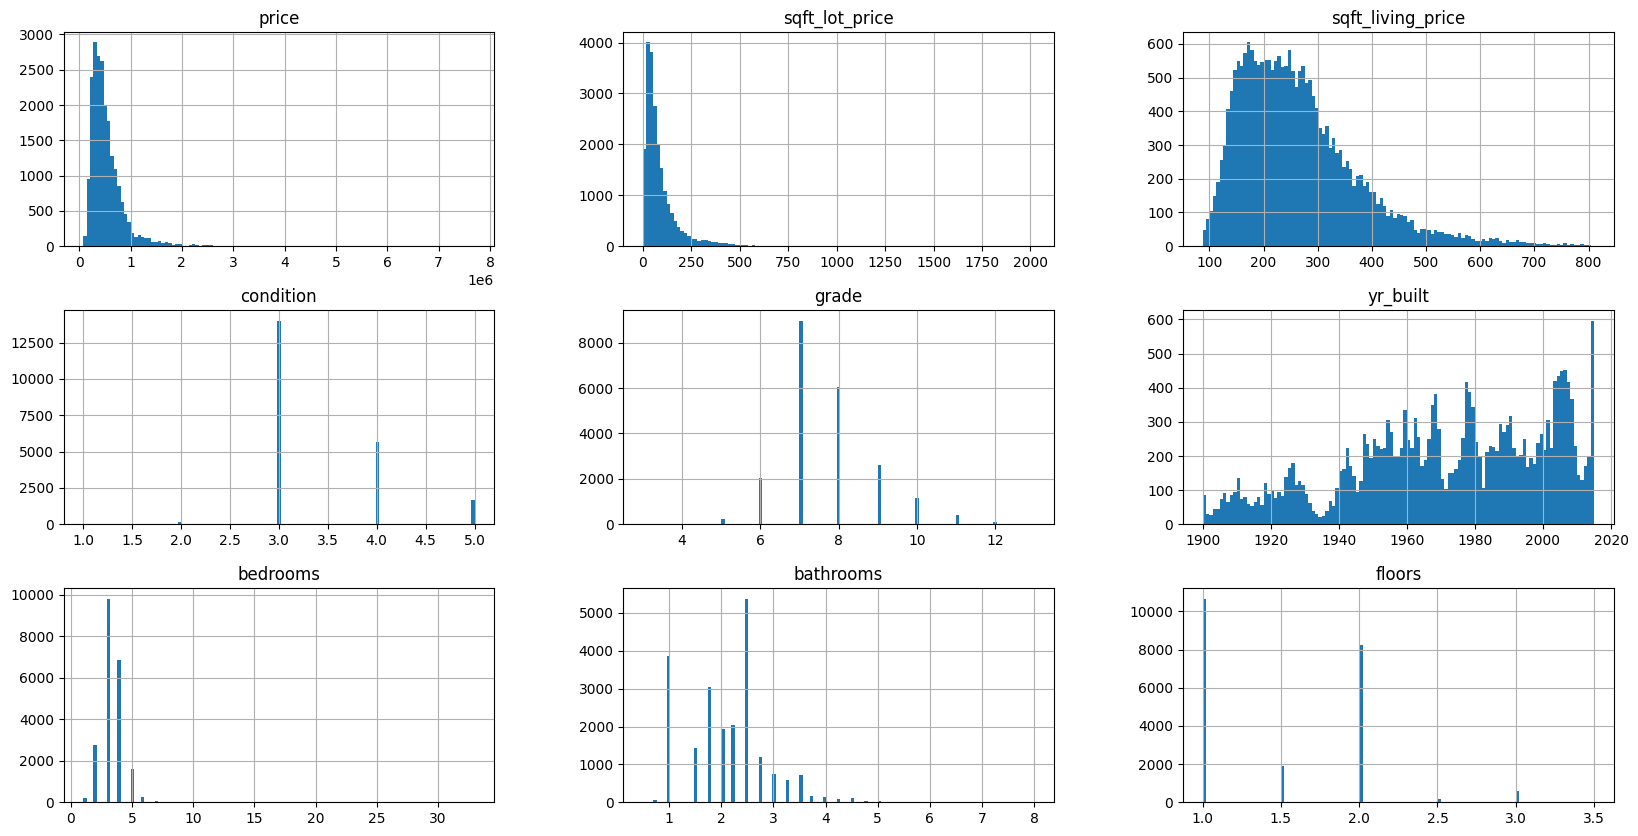

In [52]:
# get into univariate descriptive charts for the vars

#df['yr_built'].hist(bins = df['yr_built'].max() - df['yr_built'].min(), figsize=(20, 10) )
df_reno = df.query('yr_renovated_fix > 0')
#df_reno['yr_renovated_fix'].hist(bins = df_reno['yr_renovated_fix'].max() - df_reno['yr_renovated_fix'].min(), figsize=(20, 10) )

df[['price', 'sqft_lot_price', 'sqft_living_price', 'condition','grade','yr_built', 'bedrooms', 'bathrooms', 'floors' ]].hist(bins = df['yr_built'].max() - df['yr_built'].min(), figsize=(20, 10) )



In [53]:
# some basic infos
df[['grade', 'condition', 'waterfront']].describe()

grade  condition  waterfront
count 21597.000  21597.000   19206.000
mean      7.658      3.410       0.008
std       1.173      0.651       0.087
min       3.000      1.000       0.000
25%       7.000      3.000       0.000
50%       7.000      3.000       0.000
75%       8.000      4.000       0.000
max      13.000      5.000       1.000

<Axes: xlabel='zipcode'>

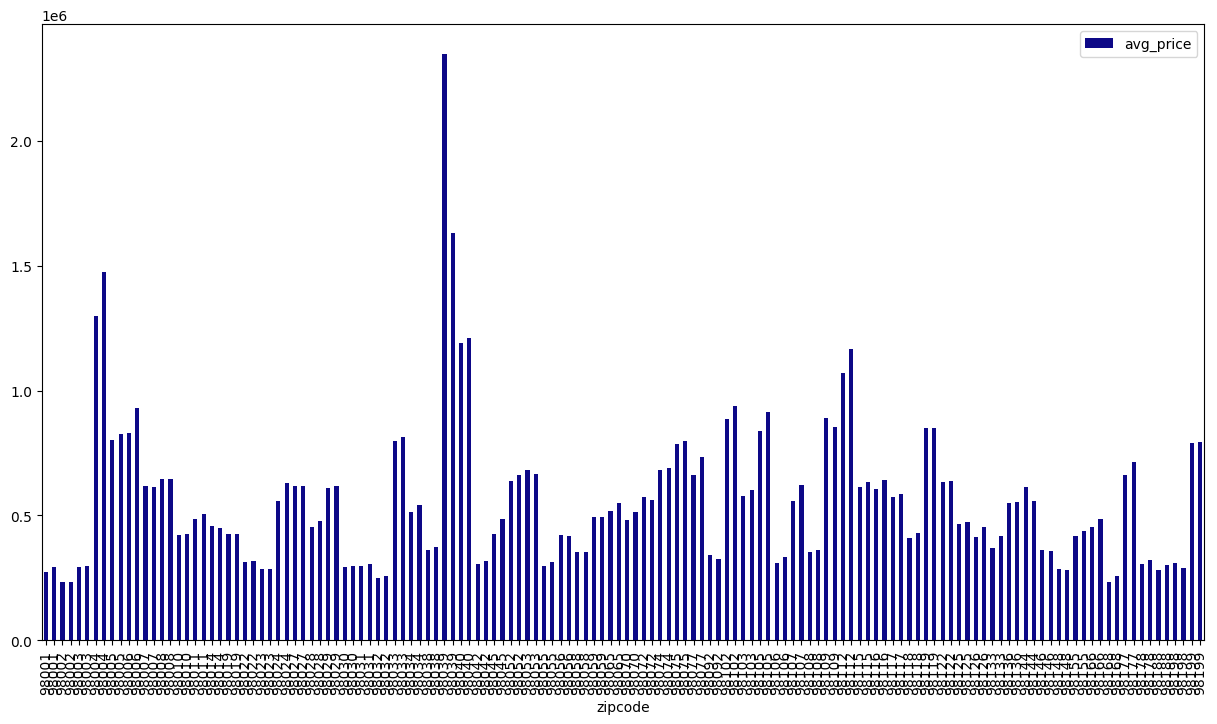

In [9]:
# now some bi-/multivariate views

#df.plot.scatter(x='waterfront', y='price')
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

# mean of overall price by neighborhood
#df.groupby('zipcode').price.mean().plot.bar(x='zipcode', y='mean', figsize=(20,10))
#df.groupby(['zipcode']).sqft_lot_price.mean().plot.bar(x='zipcode', y='mean', figsize=(20,10))

df_grouped = df.groupby(['zipcode','yr_sold']).price.mean().to_frame('avg_price').reset_index()
#df_grouped.head()
#pd.concat(df_grouped).plot.bar()

#sns.catplot(x='zipcode', y='price', hue='yr_sold', data=df_grouped, kind='bar')

df_grouped.plot.bar(x='zipcode', y='avg_price', colormap="plasma")

In [10]:
# basic correlations

corr = df.corr()
corr.style.background_gradient(cmap='seismic', axis=None).set_precision(3)

In [228]:
#
# no relationships between size, price, and condition
#


#df.query('sqft_living < 2000 and sqft_living_price < 400 ').plot.scatter(x="sqft_living", y="sqft_living_price")
#fig_prices = px.scatter(df, x="sqft_living", y="sqft_living_price", color="price", range_color=[0, 1000000] )

# prepare for categorial output and discrete color map
df_plot = df.sort_values('condition').copy()
df_plot['condition'] = df_plot['condition'].astype(str)
fig_all = px.scatter(
    df_plot,
    x="sqft_living_price",
    y="sqft_living",
    color="condition",
    opacity=0.75,
    title = "Living Space, House Condition and Price per square feet (living)",
    labels = {
        "sqft_living_price": "Price per square feet",
        "sqft_living": "Living Space (square feet)",
        "condition": "House condition"
    }
)
fig_all.show()

fig_cond = px.scatter(
    df_plot,
    x="sqft_living_price",
    y="condition",
    opacity=0.75,
    title = "Price per square feet (living) and house condition",
        labels = {
        "sqft_living_price": "Price per square feet",
        "condition": "House condition"
    }
)
fig_cond.show()

fig_space = px.scatter(
    df_plot,
    x="sqft_living_price",
    y="sqft_living",
    opacity=0.75,
    title = "Price per square feet (living) and size of living space",
        labels = {
        "sqft_living_price": "Price per square feet",
        "sqft_living": "Living Space (square feet)",
    }
)
fig_space.show()


fig_cond_space = px.scatter(
    df_plot.query('sqft_living < 5000'),
    x="condition",
    y="sqft_living",
    opacity=0.75,
    title = "Condition and size of living space (Houses < 5000 sqft)",
        labels = {
        "condition": "House condition",
        "sqft_living": "Living Space (square feet)",
    }
)
fig_cond_space.show()


In [235]:
#
# Relationship: Grade & Living Space
#
df_plot_grade = df.sort_values('grade').copy()
df_plot_grade['condition'] = df_plot_grade['condition'].astype(str)
fig_grade = px.scatter(
    df_plot_grade,
    x="grade",
    y="sqft_living",
    color="condition",
    opacity=0.5,
    title = "Living Space, House Condition and Construction Quality",
    labels = {
        "grade": "Grade (Construction Quality)",
        "sqft_living": "Living Space (square feet)",
        "condition": "House condition"
    }
)
fig_grade.show()

In [11]:
# my verbose code

#df.drop(columns=["yr_r", "yr_b"], inplace=True)

df[["sqft_living_price", "sqft_lot_price", ]].describe()

df['zipcode'].unique()

df['floors'].unique()

#df['zipcode'].groupby().floors.mean()

df.groupby(['zipcode']).floors.mean().to_frame('avg_floors').reset_index().sort_values('avg_floors')


#df['floors'].hist(by="floors")



        


zipcode  avg_floors
64    98168       1.160
7     98008       1.182
66    98178       1.185
61    98148       1.211
62    98155       1.219
..      ...         ...
42    98103       1.827
45    98107       1.835
34    98065       1.878
17    98029       1.950
41    98102       1.990

[70 rows x 2 columns]

In [99]:
df['zipcode'].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

Conclusion: Nearly no flats in data


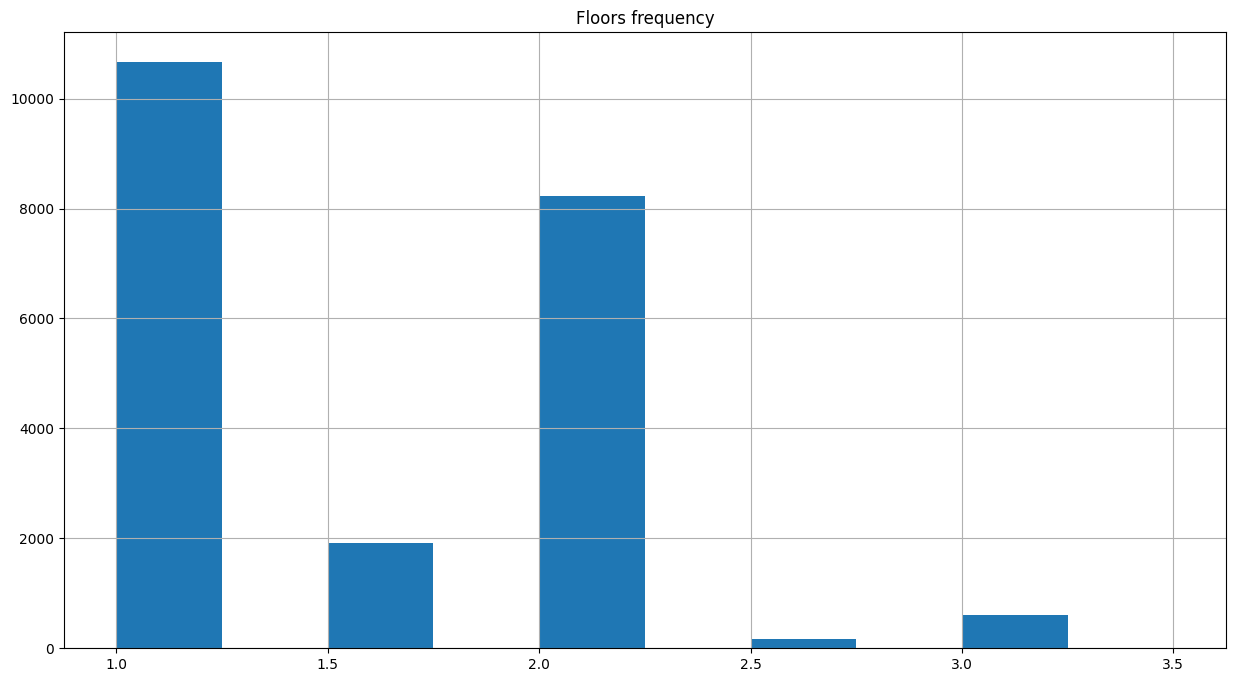

In [10]:
#
# What about apartment blocks with flats?
#
df['floors'].hist().set_title("Floors frequency")
print("Conclusion: Nearly no apartment block in the in data")

Average price in King County is: 540296.5735055795
Areas in lowest 20:
     zipcode  avg_price
1     98002 234284.035
64    98168 240328.372
20    98032 251296.240
0     98001 281194.870
61    98148 284908.596
13    98023 286742.812
67    98188 289078.346
2     98003 294111.279
18    98030 296187.980
19    98031 300340.403
68    98198 302896.739
30    98055 304262.108
66    98178 310612.756
26    98042 311580.336
12    98022 316742.391
44    98106 319581.394
40    98092 334921.063
32    98058 353619.075
46    98108 355678.516
60    98146 359496.260


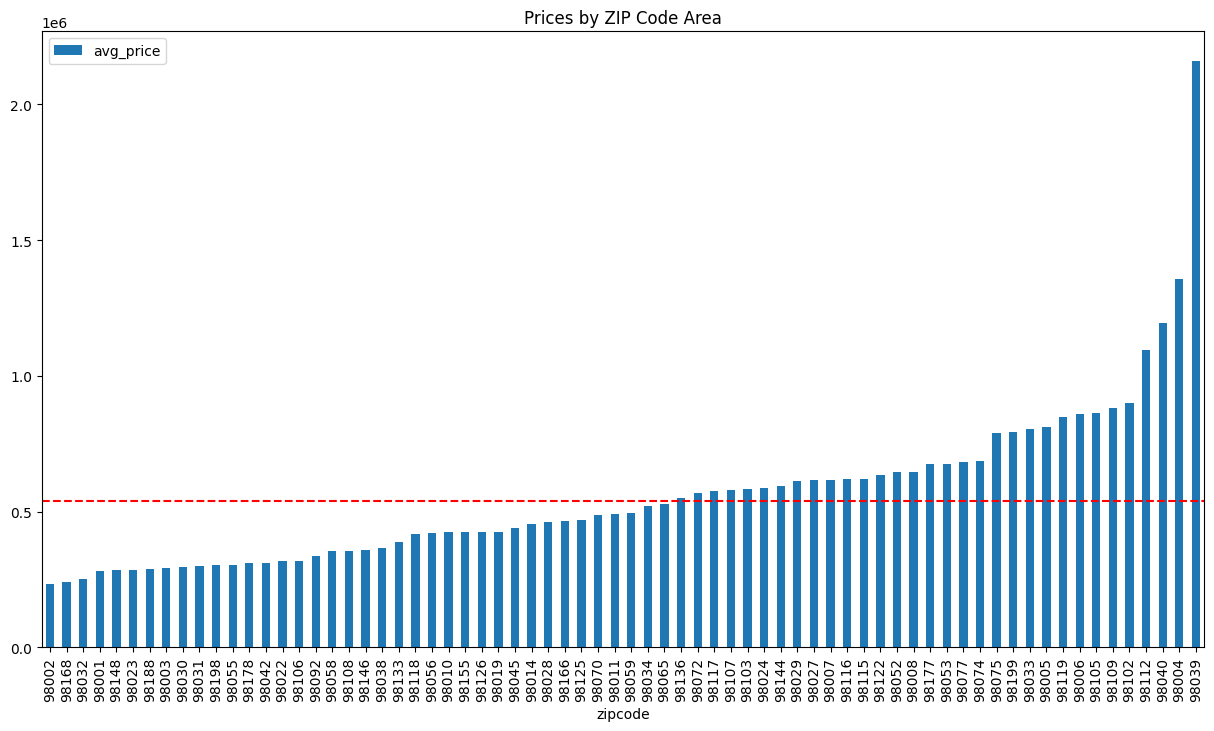

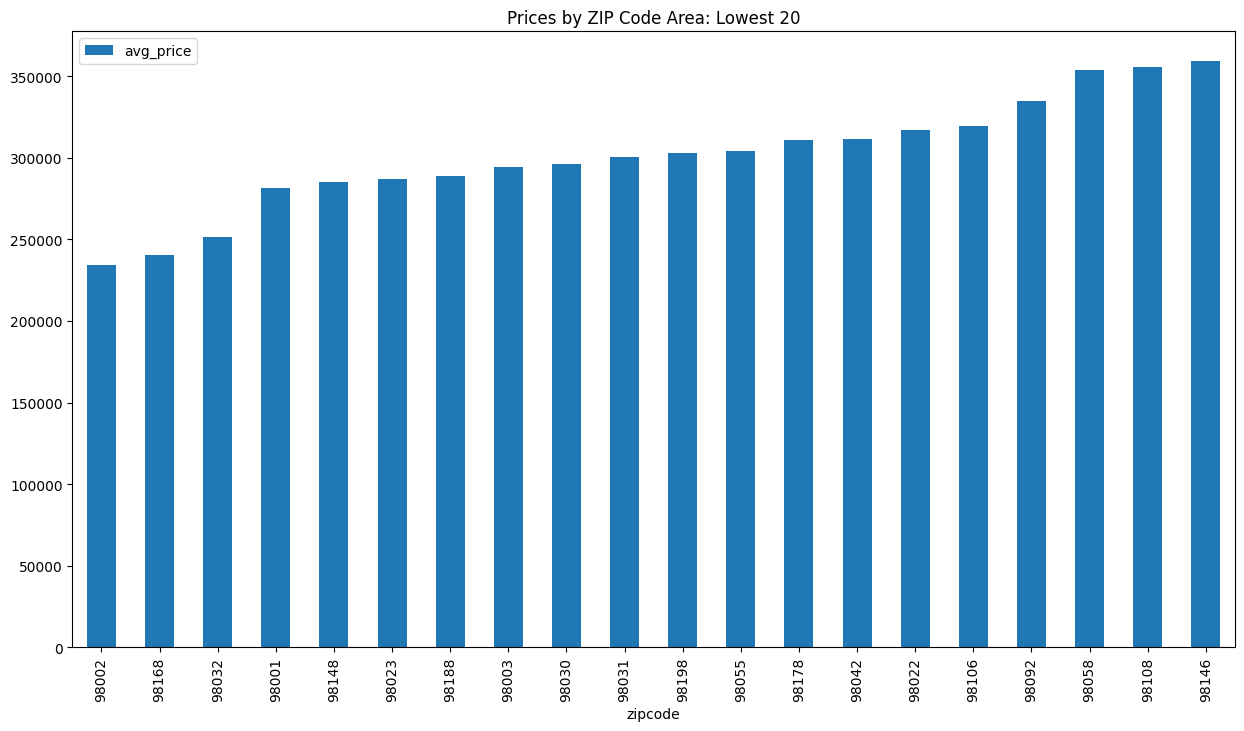

In [67]:
#
# What are neighborhoods with the lowest HOUSE prices?
#
df_prices = df.groupby(['zipcode']).price.mean().to_frame('avg_price').reset_index().sort_values('avg_price')
ax_p1 = df_prices.plot.bar(x='zipcode').set_title('Prices by ZIP Code Area')
plt.axhline(df.price.mean(), color="red", ls="--")
ax_p2 = df_prices.head(20).plot.bar(x='zipcode').set_title('Prices by ZIP Code Area: Lowest 20')

print(f"Average price in King County is: {df.price.mean()}")
print(f"Areas in lowest 20:\n {df_prices.head(20)}")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bedrooms           21597 non-null  float64       
 1   bathrooms          21597 non-null  float64       
 2   sqft_living        21597 non-null  float64       
 3   sqft_lot           21597 non-null  float64       
 4   floors             21597 non-null  float64       
 5   waterfront         19206 non-null  float64       
 6   view               21534 non-null  float64       
 7   condition          21597 non-null  int64         
 8   grade              21597 non-null  int64         
 9   sqft_above         21597 non-null  float64       
 10  sqft_basement      21145 non-null  float64       
 11  yr_built           21597 non-null  int64         
 12  yr_renovated       17749 non-null  float64       
 13  zipcode            21597 non-null  int64         
 14  lat   

In [138]:
# investigate in areas and check for gentrification
# we need:
#  - zipcode
#  - avg price 2014
#  - avg price 2015
#  - rate of increase/decrease from 2014 to 2015

df_prices2 = df.groupby(['zipcode', 'yr_sold']).price.mean().to_frame('avg_price').reset_index().sort_values('avg_price')
#print(f"Areas in lowest 20:\n {df_prices2.head()}")
df_p2014 = df_prices2.query('yr_sold == 2014')
df_p2014.drop(columns='yr_sold', inplace=True)
df_p2014.rename(columns={"avg_price": "avg_price_2014"}, inplace=True)

df_p2015 = df_prices2.query('yr_sold == 2015')
df_p2015.drop(columns='yr_sold', inplace=True)
df_p2015.rename(columns={"avg_price": "avg_price_2015"}, inplace=True)

df_ap_zip = pd.merge(df_p2014, df_p2015, on='zipcode')

df_ap_zip.eval('diff_2014_2015 = avg_price_2015 - avg_price_2014', inplace=True)
df_ap_zip.eval('diff_percent = ((avg_price_2015/avg_price_2014)-1) * 100', inplace=True)

df_sold_zip = df.groupby('zipcode').price.count().to_frame('houses_sold').reset_index().sort_values('zipcode')
df_ap_zip = pd.merge(df_ap_zip, df_sold_zip, on='zipcode')
df_ap_zip.sort_values('diff_percent', ascending=True).head(20)


#df['zipcode'].nunique()

#print(f"Areas in lowest 20:\n {df_pby_pivot.head()}")

zipcode  avg_price_2014  avg_price_2015  diff_2014_2015  diff_percent  \
69    98039     2348310.811     1629038.462     -719272.349       -30.629   
46    98144      613411.797      558102.293      -55309.504        -9.017   
13    98198      310049.022      289613.929      -20435.093        -6.591   
16    98092      339810.788      326080.440      -13730.348        -4.041   
65    98109      889589.557      855030.000      -34559.557        -3.885   
42    98072      574696.506      561685.423      -13011.083        -2.264   
55    98053      681425.140      667742.298      -13682.841        -2.008   
31    98014      457489.587      450233.750       -7255.837        -1.586   
25    98056      422893.306      417140.688       -5752.618        -1.360   
5     98148      285849.744      282869.444       -2980.299        -1.043   
49    98007      618555.891      613966.800       -4589.091        -0.742   
18    98058      354341.565      352324.798       -2016.768        -0.569   
19    98146      360114.787      358552.193       -1562.594        -0.434   
63    98119      850328.962      848236.296       -2092.665        -0.246   
27    98019      425117.435      424246.970        -870.466        -0.205   
35    98059      493669.082      493534.309        -134.773        -0.027   
52    98008      645618.306      645649.500          31.194         0.005   
6     98023      286667.937      286895.756         227.819         0.079   
1     98002      234215.780      234418.507         202.727         0.087   
26    98010      423160.371      424490.947        1330.576         0.314   

    houses_sold  
69           50  
46          343  
13          280  
16          351  
65          109  
42          273  
55          403  
31          124  
25          406  
5            57  
49          141  
18          455  
19          288  
63          184  
27          190  
35          468  
52          283  
6           499  
1           199  
26          100

In [ ]:
# 
# check for ZIP-Code areas with no house sales (missing data?)
#

# use df_sold_zip from previous block

# zipcode area as geojson layer
with open('data/kc_zipcode_geo.json') as gj:
    zip_geojson = json.load(gj)

fig = px.choropleth_mapbox(df_sold_zip, 
                           geojson=zip_geojson, 
                           locations='zipcode',
                           featureidkey="properties.ZIP",
                           color='houses_sold',
                           color_continuous_scale="Plasma",
                           range_color=(-10, 15),
                           hover_data=['zipcode', 'houses_sold'],
                           mapbox_style="open-street-map",
                           zoom=9,
                           height=800,
                           center = {"lat": 47.45, "lon": -121.9},
                           opacity=0.65,
                           labels={"houses_sold":"Houses Sold", 'zipcode':'ZIP'}
                           )

In [240]:
#
# development of avg sqft living prices
#

df_prices3 = df.groupby(['zipcode', 'yr_sold']).sqft_living_price.mean().to_frame('avg_sqft_price').reset_index().sort_values('zipcode')

df_sp2014 = df_prices3.query('yr_sold == 2014')
df_sp2014.drop(columns='yr_sold', inplace=True)
df_sp2014.rename(columns={"avg_sqft_price": "avg_sqft_price_2014"}, inplace=True)

df_sp2015 = df_prices3.query('yr_sold == 2015')
df_sp2015.drop(columns='yr_sold', inplace=True)
df_sp2015.rename(columns={"avg_sqft_price": "avg_sqft_price_2015"}, inplace=True)

df_ap_sqft_zip = pd.merge(df_sp2014, df_sp2015, on='zipcode')

df_ap_sqft_zip.eval('diff_sqft_2014_2015 = avg_sqft_price_2015 - avg_sqft_price_2014', inplace=True)
df_ap_sqft_zip.eval('diff_sqft_pct = ((avg_sqft_price_2015/avg_sqft_price_2014)-1) * 100', inplace=True)

# needs df_sold_zip from previous block
df_ap_sqft_zip = pd.merge(df_ap_sqft_zip, df_sold_zip, on='zipcode')
df_ap_sqft_zip.sort_values('diff_sqft_pct', ascending=True).head(20)

zipcode  avg_sqft_price_2014  avg_sqft_price_2015  diff_sqft_2014_2015  \
8     98010              222.838              189.305              -33.532   
35    98070              280.476              269.503              -10.973   
6     98007              292.523              283.948               -8.575   
47    98109              435.066              429.593               -5.473   
66    98178              189.804              187.654               -2.150   
10    98014              223.474              221.964               -1.511   
20    98032              154.089              154.519                0.430   
24    98039              567.785              569.542                1.758   
19    98031              160.705              161.858                1.153   
41    98102              421.261              431.303               10.042   
18    98030              153.582              157.573                3.991   
2     98003              155.578              160.055                4.477   
12    98022              180.324              185.580                5.256   
69    98199              373.101              384.055               10.954   
36    98072              244.942              252.256                7.314   
31    98056              213.293              219.756                6.463   
27    98045              217.690              224.356                6.666   
62    98155              243.921              252.101                8.180   
16    98028              222.465              230.205                7.739   
17    98029              269.371              278.784                9.413   

    diff_sqft_pct  houses_sold  
8         -15.048          100  
35         -3.912          117  
6          -2.931          141  
47         -1.258          109  
66         -1.133          262  
10         -0.676          124  
20          0.279          125  
24          0.310           50  
19          0.718          273  
41          2.384          104  
18          2.599          256  
2           2.878          280  
12          2.915          233  
69          2.936          317  
36          2.986          273  
31          3.030          406  
27          3.062          220  
62          3.354          446  
16          3.479          283  
17          3.495          321

In [241]:
df_ap_sqft_zip.shape

(70, 6)

In [98]:
# investigate in condition

df_cond = df.groupby(['condition', 'yr_sold']).price.mean().to_frame('avg_price').reset_index().sort_values('avg_price')

df_c_p2014 = df_cond.query('yr_sold == 2014')
df_c_p2014.drop(columns='yr_sold', inplace=True)
df_c_p2014.rename(columns={"avg_price": "avg_price_2014"}, inplace=True)

df_c_p2015 = df_cond.query('yr_sold == 2015')
df_c_p2015.drop(columns='yr_sold', inplace=True)
df_c_p2015.rename(columns={"avg_price": "avg_price_2015"}, inplace=True)

df_ap_cond = pd.merge(df_c_p2014, df_c_p2015, on='condition')

df_ap_cond.eval('diff_2014_2015 = avg_price_2015 - avg_price_2014', inplace=True)
df_ap_cond.eval('diff_percent = ((avg_price_2015/avg_price_2014)-1) * 100', inplace=True)

df_sold_cond = df.groupby('condition').price.count().to_frame('houses_sold').reset_index().sort_values('condition')
df_ap_cond = pd.merge(df_ap_cond, df_sold_cond, on='condition')
df_ap_cond.sort_values('condition', ascending=True).head(20)

condition  avg_price_2014  avg_price_2015  diff_2014_2015  diff_percent  \
0          1      285497.222      432000.000      146502.778        51.315   
1          2      312891.400      350017.843       37126.443        11.866   
3          3      539991.025      546544.600        6553.575         1.214   
2          4      521082.495      522001.759         919.264         0.176   
4          5      611339.037      616320.215        4981.178         0.815   

   houses_sold  
0           29  
1          170  
3        14020  
2         5677  
4         1701

In [70]:
df_prices2.sort_values('zipcode').head()

zipcode  yr_sold  avg_price
0    98001     2014 275250.869
1    98001     2015 293749.009
2    98002     2014 234215.780
3    98002     2015 234418.507
4    98003     2014 292311.717

Average SQFT (Living) price in King County is: 264.1433683790251
Areas in lowest 20:
     zipcode  avg_sqft_price
13    98023         148.922
1     98002         151.174
0     98001         151.348
20    98032         154.220
18    98030         155.156
40    98092         155.814
2     98003         157.113
19    98031         161.102
26    98042         164.378
67    98188         169.007
23    98038         173.728
64    98168         175.373
32    98058         178.206
68    98198         178.434
30    98055         180.402
12    98022         182.106
61    98148         185.832
66    98178         189.173
11    98019         203.007
33    98059         207.260


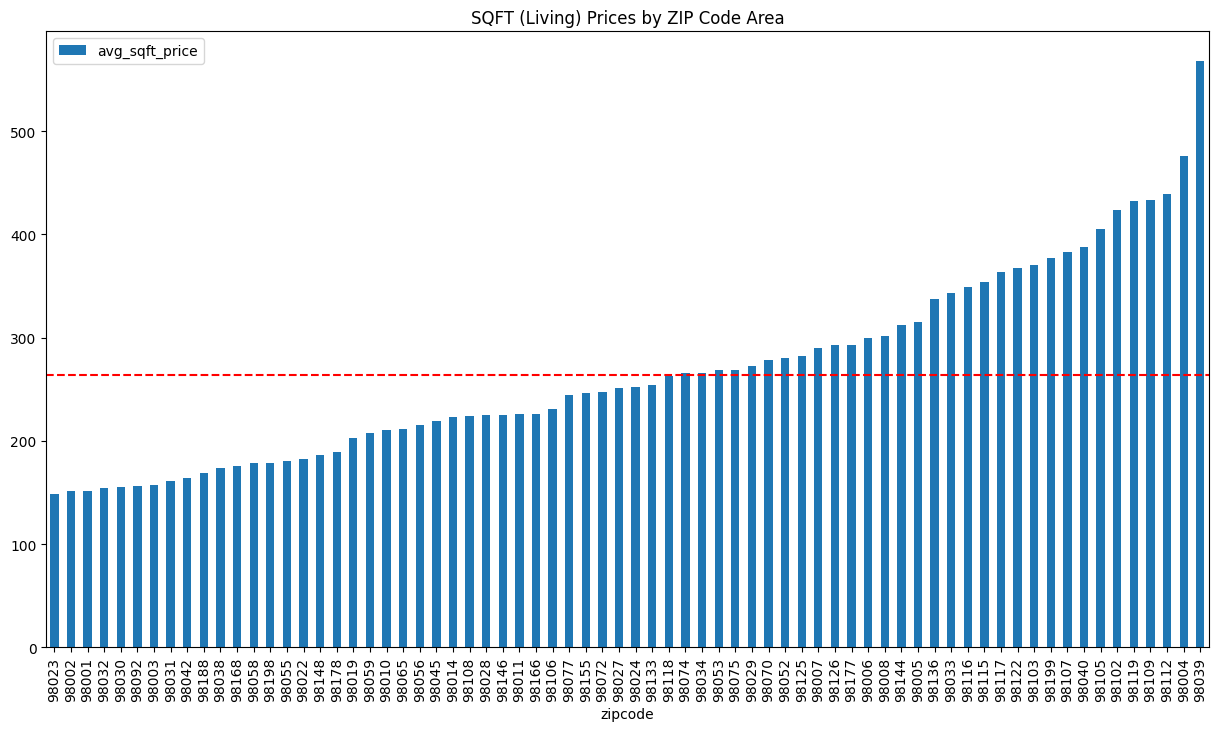

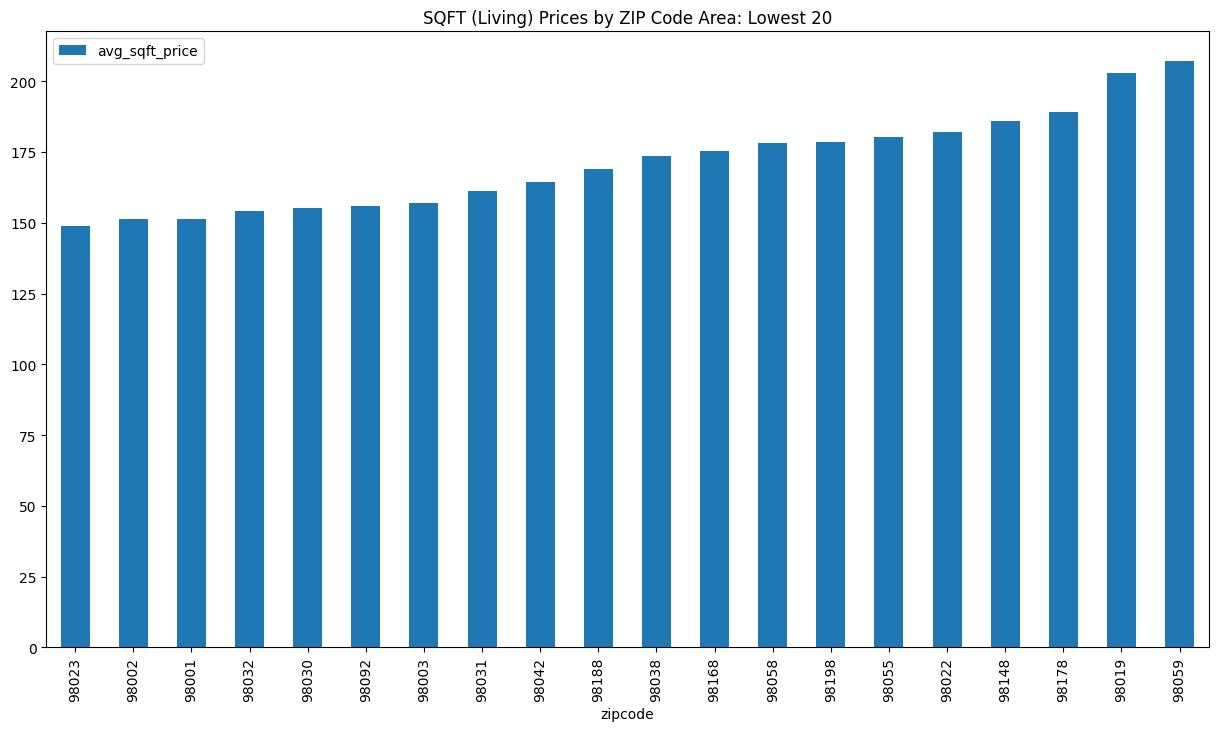

In [12]:
#
# What are neighborhoods with the lowest prices per SQFT Living?
#
df_sqliv_prices = df.groupby(['zipcode']).sqft_living_price.mean().to_frame('avg_sqft_price').reset_index().sort_values('avg_sqft_price')
ax_p3 = df_sqliv_prices.plot.bar(x='zipcode').set_title('SQFT (Living) Prices by ZIP Code Area')
plt.axhline(df.sqft_living_price.mean(), color="red", ls="--", label="Avg")

ax_p4 = df_sqliv_prices.head(20).plot.bar(x='zipcode').set_title('SQFT (Living) Prices by ZIP Code Area: Lowest 20')

print(f"Average SQFT (Living) price in King County is: {df.sqft_living_price.mean()}")
print(f"Areas in lowest 20:\n {df_sqliv_prices.head(20)}")


In [139]:
#
# Now have look at house age, grade and whether renovated or not
#

# first, remove houses that have been sold more than once
df_houses = df.drop(columns=['yr_sold' ,'date', 'date2', 'price', 'sales_id', 'sqft_lot_price', 'sqft_living_price'])
df_houses.drop_duplicates(inplace=True)
df_houses.shape


print("\nOldest Houses\n")
print(df_houses.groupby(['zipcode']).yr_built.mean().to_frame('avg_built').reset_index().sort_values('avg_built').head(20))


print("\n\n\nLowest avg. Grade\n")
print(df_houses.groupby(['zipcode']).grade.mean().to_frame('avg_grade').reset_index().sort_values('avg_grade').head(20))


#ax_p1 = df_prices.plot.bar(x='zipcode').set_title('Prices by ZIP Code Area')
#plt.axhline(df.price.mean(), color="red", ls="--")
#ax_p2 = df_prices.head(20).plot.bar(x='zipcode').set_title('Prices by ZIP Code Area: Lowest 20')

#print(f"Average price in King County is: {df.price.mean()}")
#print(f"Areas in lowest 20:\n {df_prices.head(20)}")




Oldest Houses

    zipcode  avg_built
43    98105   1940.406
47    98109   1944.028
48    98112   1944.269
53    98119   1947.620
51    98117   1948.422
49    98115   1949.043
54    98122   1949.931
52    98118   1950.620
41    98102   1952.163
64    98168   1952.784
56    98126   1952.923
42    98103   1953.105
50    98116   1953.802
66    98178   1955.326
59    98144   1955.385
60    98146   1956.114
69    98199   1956.570
58    98136   1956.703
46    98108   1957.676
63    98166   1957.728



Lowest avg. Grade

    zipcode  avg_grade
64    98168      6.523
1     98002      6.695
66    98178      6.829
60    98146      6.836
44    98106      6.876
61    98148      6.982
52    98118      6.988
46    98108      7.016
56    98126      7.034
67    98188      7.044
68    98198      7.109
57    98133      7.128
30    98055      7.146
20    98032      7.146
62    98155      7.174
12    98022      7.176
55    98125      7.192
51    98117      7.283
35    98070      7.293
0     98001      7.

### About King County's Housing Grade System ###

__Grade__ is a:

> Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value. (See Glossary in Area Report for Residential Building Grades in use by the King County Department of Assessments.)

Source: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#g

In [140]:
# look at grade first, than yr_built

df_grades_l20 = df_houses.groupby(['zipcode']).agg({'grade':'mean', 'yr_built': 'mean'}).sort_values('grade')


#.grade.mean().to_frame('avg_grade').reset_index().sort_values('avg_grade').head(20).yr_built.mean()

df_grades_l20.head(20)

### REFINEMENT: 
### Finding: avg grade is at 7.6. , zipcode with lowest avg grade has 6.5 (98168)
### Conclusion: Don't use avg grade, but look for areas where houses with grade 6 and below are

grade  yr_built
zipcode                 
98168    6.523  1952.784
98002    6.695  1967.695
98178    6.829  1955.326
98146    6.836  1956.114
98106    6.876  1965.812
98148    6.982  1963.821
98118    6.988  1950.620
98108    7.016  1957.676
98126    7.034  1952.923
98188    7.044  1965.681
98198    7.109  1966.865
98133    7.128  1963.475
98055    7.146  1969.827
98032    7.146  1965.577
98155    7.174  1961.181
98022    7.176  1971.541
98125    7.192  1960.107
98117    7.283  1948.422
98070    7.293  1967.888
98001    7.296  1981.047

In [236]:
# are there clusters with house grades 6 and below?

#plotly map
fig = px.scatter_mapbox(
    df_houses.query('grade <= 5'),
    lat='lat',
    lon='long',
    hover_data=['grade', 'condition', 'yr_built', 'yr_renovated', 'yr_renovated_fix']
    #color='grade',
    #color_continuous_scale=px.colors.sequential.BuPu_r,
)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [237]:
# and what about houses with low condition?

fig = px.scatter_mapbox(
    df_houses.query('condition <= 2'),
    lat='lat',
    lon='long',
    hover_data=['grade', 'condition', 'yr_built', 'yr_renovated', 'yr_renovated_fix']
    #color='grade',
    #color_continuous_scale=px.colors.sequential.BuPu_r,
)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [262]:
#
# map view:
# development of avg HOUSE price 
# combined with houses in low condition
#


# zipcode area as geojson layer
with open('data/kc_zipcode_geo.json') as gj:
    zip_geojson = json.load(gj)

fig = px.choropleth_mapbox(df_ap_zip, 
                           geojson=zip_geojson, 
                           locations='zipcode',
                           featureidkey="properties.ZIP",
                           color='diff_percent',
                           color_continuous_scale="Plasma",
                           range_color=(-10, 15),
                           hover_data=['zipcode', 'diff_percent', 'houses_sold'],
                           mapbox_style="open-street-map",
                           zoom=9,
                           height=800,
                           center = {"lat": 47.45, "lon": -121.9},
                           opacity=0.65,
                           labels={'diff_percent':'(%)', 'zipcode':'ZIP', 'houses_sold': 'Houses Sold'}
                           )

fig_cond = px.scatter_mapbox(
        df_houses.query('condition <= 2'),
        lat='lat',
        lon='long',
        color='condition',
        #color_continuous_scale="OrRd",
        #range_color=(0, 2),
        #opacity=1,
        hover_data=['grade', 'condition', 'yr_built', 'yr_renovated', 'yr_renovated_fix'],
        title="Titel"
)

fig.add_trace(fig_cond.data[0])

fig.update_layout(
    margin = {"r":0,"t":0,"l":0,"b":0},
    title_text = "Meine tolle Karte",
    title_font_size=20
    )

fig.show()

In [244]:
df_ap_sqft_zip.describe()

zipcode  avg_sqft_price_2014  avg_sqft_price_2015  \
count    70.000               70.000               70.000   
mean  98077.300              262.851              276.914   
std      56.622               90.208               96.130   
min   98001.000              146.841              153.170   
25%   98029.250              191.803              193.864   
50%   98067.500              245.520              261.786   
75%   98117.750              309.230              325.868   
max   98199.000              567.785              569.542   

       diff_sqft_2014_2015  diff_sqft_pct  houses_sold  
count               70.000         70.000       70.000  
mean                14.063          5.217      308.529  
std                 13.957          4.709      142.224  
min                -33.532        -15.048       50.000  
25%                  7.003          3.385      204.250  
50%                 11.435          4.928      282.500  
75%                 18.828          7.151      408.250  
max                 50.785         18.045      602.000

In [261]:
#
# map view:
# development of avg SQFT (LIVING) price 
# combined with houses in low condition
#


# zipcode area as geojson layer
with open('data/kc_zipcode_geo.json') as gj:
    zip_geojson = json.load(gj)

fig = px.choropleth_mapbox(df_ap_sqft_zip, 
                           geojson=zip_geojson, 
                           locations='zipcode',
                           featureidkey="properties.ZIP",
                           color='diff_sqft_pct',
                           color_continuous_scale="Viridis",
                           range_color=(-10, 15),
                           hover_data=['zipcode', 'diff_sqft_pct', 'houses_sold'],
                           mapbox_style="open-street-map",
                           zoom=9,
                           height=800,
                           center = {"lat": 47.45, "lon": -121.9},
                           opacity=0.65,
                           labels={'diff_sqft_pct':'(%)', 'zipcode':'ZIP', 'houses_sold': 'Houses Sold'}
                           )

fig_cond = px.scatter_mapbox(
        df_houses.query('condition <= 2'),
        lat='lat',
        lon='long',
        color='condition',
        #color_continuous_scale="OrRd",
        #range_color=(0, 2),
        #opacity=1,
        hover_data=['grade', 'condition', 'yr_built', 'yr_renovated', 'yr_renovated_fix']
)

fig.add_trace(fig_cond.data[0])

fig.update_layout(
    margin = {"r":0,"t":0,"l":0,"b":0},
    title_text = "Price Development of Living Space (sqft) 2014-2015",
    title_font_size=20
    )

fig.show()

In [114]:
# debugging / data checks
df_ap_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zipcode         70 non-null     int64  
 1   avg_price_2014  70 non-null     float64
 2   avg_price_2015  70 non-null     float64
 3   diff_2014_2015  70 non-null     float64
 4   diff_percent    70 non-null     float64
 5   houses_sold     70 non-null     int64  
dtypes: float64(4), int64(2)
memory usage: 3.8 KB
